**Read and display the given binary image.**

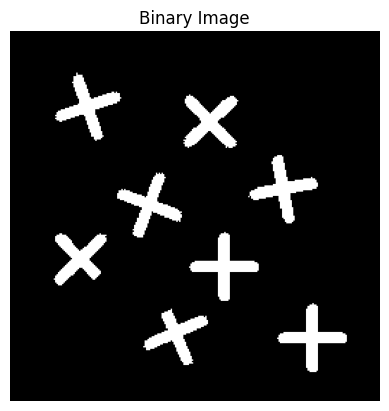

In [25]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load the image
image_path = 'Image_01.bmp'
image = Image.open(image_path)

# Display the image
plt.imshow(image, cmap='gray')
plt.title("Binary Image")
plt.axis("off")
plt.show()

- **Using 8-Connectivity, write the code to label each object. Refer to the lecture notes for the algorithm. Do not use the built-in functions.**

- **The code should display the equivalency table, and the final total number of objects found in the image.**

- **Assign different colors to the objects to get the resulting image as shown on the right side. (The output colors may vary).**


Equivalent Table:
Label 2 -> {32, 1, 2, 3, 4, 5, 6, 7, 33, 9, 12, 18, 20, 22, 24, 26, 28, 30}
Label 10 -> {8, 10, 11, 13, 14, 15, 16, 17, 19, 21, 23, 25, 27, 29, 31, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45}
Label 47 -> {66, 68, 70, 73, 46, 47, 48, 49, 55, 56, 58, 60, 61, 63}
Label 71 -> {50, 51, 52, 53, 54, 57, 59, 62, 64, 65, 67, 69, 71, 72, 74, 75, 76, 77, 78, 79, 80}
Label 84 -> {102, 104, 106, 109, 81, 84, 87, 91}
Label 88 -> {82, 83, 85, 86, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 105, 107, 108, 110, 111, 112, 113, 114, 115, 116}
Label 118 -> {134, 136, 138, 141, 117, 118, 119, 121}
Label 122 -> {128, 129, 130, 131, 132, 133, 135, 137, 139, 140, 142, 143, 144, 120, 122, 123, 124, 125, 126, 127}
Total number of objects found: 8


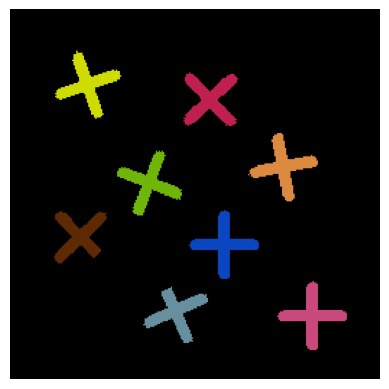

In [23]:
# Define directions for 8-bit connectivity (all 8 neighbors)
directions = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]

def read_and_process_image(image_path):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img_array = np.array(img)
    binary_image = np.where(img_array > 128, 1, 0)  # Binarize image
    return binary_image

def label_image_pass_1(image):
    labels = np.zeros_like(image, dtype=int)
    equivalence_table = {}
    current_label = 1

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i, j] == 1:
                # Neighbors: top (i-1, j), left (i, j-1), top-left (i-1, j-1), top-right (i-1, j+1)
                neighbor_labels = []

                # Top, Left, Top-left, and Top-right neighbors
                if i > 0 and image[i-1, j] == 1:  # Top
                    neighbor_labels.append(labels[i-1, j])
                if j > 0 and image[i, j-1] == 1:  # Left
                    neighbor_labels.append(labels[i, j-1])
                if i > 0 and j > 0 and image[i-1, j-1] == 1:  # Top-left
                    neighbor_labels.append(labels[i-1, j-1])
                if i > 0 and j < image.shape[1]-1 and image[i-1, j+1] == 1:  # Top-right
                    neighbor_labels.append(labels[i-1, j+1])

                if len(neighbor_labels) == 0:
                    # No neighbors, assign a new label
                    labels[i, j] = current_label
                    equivalence_table[current_label] = {current_label}
                    current_label += 1
                else:
                    # If only one neighbor has a label, copy that label
                    if len(set(neighbor_labels)) == 1:
                        labels[i, j] = neighbor_labels[0]
                    else:
                        # Multiple neighbors with different labels, we must handle the equivalence
                        left_label = labels[i, j-1] if j > 0 else -1
                        if left_label != -1:
                            labels[i, j] = left_label
                            for neighbor in set(neighbor_labels):
                                if neighbor != left_label:
                                    # Merge equivalence classes of different labels
                                    if left_label not in equivalence_table:
                                        equivalence_table[left_label] = set()
                                    equivalence_table[left_label].add(neighbor)
                        else:
                            labels[i, j] = current_label
                            equivalence_table[current_label] = {current_label}
                            current_label += 1
    return labels, equivalence_table

def find(label, parent):
    if parent[label] != label:
        parent[label] = find(parent[label], parent)
    return parent[label]

def union(label1, label2, parent, rank):
    root1 = find(label1, parent)
    root2 = find(label2, parent)
    if root1 != root2:
        if rank[root1] > rank[root2]:
            parent[root2] = root1
        elif rank[root1] < rank[root2]:
            parent[root1] = root2
        else:
            parent[root2] = root1
            rank[root1] += 1

def relabel_pass_2(labels, equivalence_table):
    # Initialize Union-Find structure
    parent = {label: label for label in equivalence_table.keys()}
    rank = {label: 0 for label in equivalence_table.keys()}

    # Union equivalent labels
    for label, equivalents in equivalence_table.items():
        for equivalent in equivalents:
            union(label, equivalent, parent, rank)

    # Flatten equivalence classes to map each label to its root
    label_map = {}
    for label in parent.keys():
        root = find(label, parent)
        label_map[label] = root

    # Print the final resolved equivalence table
    resolved_table = {}
    print(f"Equivalent Table:")
    for label, root in label_map.items():
        if root not in resolved_table:
            resolved_table[root] = set()
        resolved_table[root].add(label)
    for root_label, labelss in resolved_table.items():
        print(f"Label {root_label} -> {labelss}")

    # Relabel the image using the resolved equivalence classes
    new_labels = np.copy(labels)
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            if labels[i, j] != 0:
                new_labels[i, j] = label_map[labels[i, j]]
    
    return new_labels


def color_labeled_image(labels):
    output_image = np.zeros((labels.shape[0], labels.shape[1], 3), dtype=np.uint8)
    label_colors = {}

    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            label = labels[i, j]
            if label > 0:  # Skip background
                if label not in label_colors:
                    label_colors[label] = np.random.randint(0, 255, size=3)  # Random color for each label
                output_image[i, j] = label_colors[label]

    return output_image

def main(image_path):
    binary_image = read_and_process_image(image_path)

    # Pass 1: Labeling connected components
    labels, equivalence_table = label_image_pass_1(binary_image)

    # Pass 2: Relabel with the smallest equivalent label
    relabeled_image = relabel_pass_2(labels, equivalence_table)

    # Count unique labels (distinct objects) in the relabeled image
    unique_labels = set(np.unique(relabeled_image)) - {0}  # Exclude background (0)
    print(f"Total number of objects found: {len(unique_labels)}")

    # Color the labeled image for display
    colored_image = color_labeled_image(relabeled_image)

    # Display the result
    plt.imshow(colored_image)
    plt.axis('off')
    plt.show()

# Example usage
main(image_path)
